In [128]:
import pandas as pd
from pandas.tseries.offsets import DateOffset

import matplotlib.pyplot as plt

from prophet import Prophet
import statsmodels.api as sm # for ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

from statsmodels.tsa.stattools import adfuller


In [147]:
df = pd.read_csv("power_data.csv", parse_dates = ["Datetime"])
df.drop(columns = ["Unnamed: 0"], inplace = True)
df.head()

#Data included a column called "Unnamed: 0" which is not relevant to the analysis, therefore it was removed.

,Datetime,Power_MWH
0,2010-01-01 00:00:00,31647.0
1,2010-12-31 01:00:00,29634.0
2,2010-12-31 02:00:00,28614.0
3,2010-12-31 03:00:00,28146.0
4,2010-12-31 04:00:00,28051.0


### Exploratory Data Analysis

In [130]:
df.dtypes

Datetime     datetime64[ns]
Power_MWH           float64
dtype: object

* Datetime column datetime type so it's correct.
* Power_MWH is float datatype which is good, so no need to do any changes in there.

In [131]:
df.shape
# Dimension of the datafram: 75,255 rows and two columns.

(75255, 2)

In [132]:
# Are there missing values in the data?
df.isna().sum()

# No, there are not

Datetime     0
Power_MWH    0
dtype: int64

In [133]:
# Energy consumption distribution
df["Power_MWH"].describe()

count    75255.000000
mean     31729.893575
std       6503.002099
min      14544.000000
25%      27233.500000
50%      30838.000000
75%      35353.500000
max      61646.000000
Name: Power_MWH, dtype: float64

<AxesSubplot:>

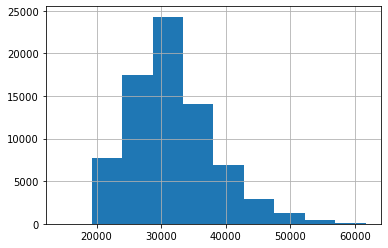

In [134]:
df["Power_MWH"].hist()

It has heavy tails on the right, which is a sigh of outliers

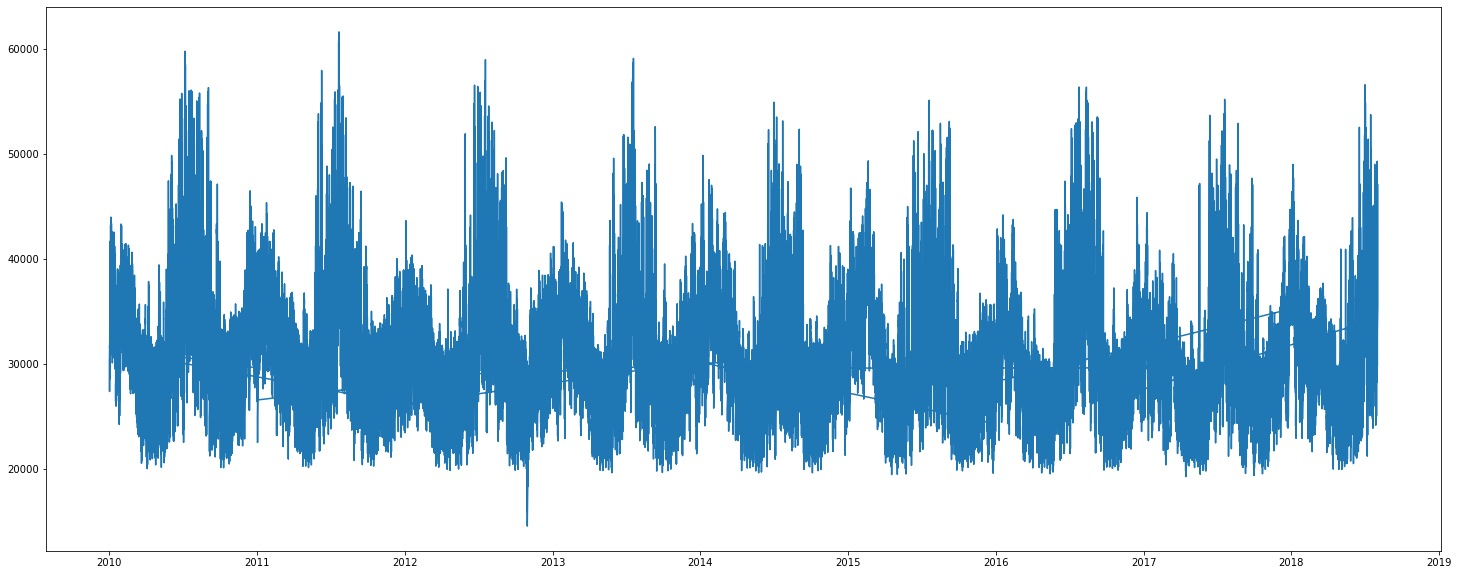

In [148]:
# Series plot
plt.figure(figsize=(25, 10))
plt.plot(df["Datetime"], df["Power_MWH"])
plt.show()

There are some weird lines cross the plot. Plotting a few values to see what is happening.

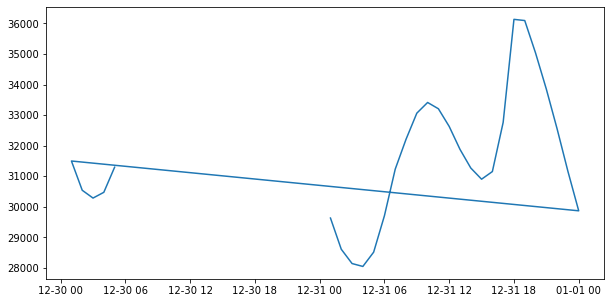

In [149]:
plt.figure(figsize=(10, 5))
plt.plot(df["Datetime"][1:30] , df["Power_MWH"][1:30])
plt.show()

The problem seems to be that the *Datetime* column is no in the right order.

In [150]:
df2 = df.sort_values(by = ["Datetime"], ascending = True)
df2.head(5)

,Datetime,Power_MWH
0,2010-01-01 00:00:00,31647.0
8734,2010-01-01 01:00:00,30075.0
8735,2010-01-01 02:00:00,28907.0
8736,2010-01-01 03:00:00,27906.0
8737,2010-01-01 04:00:00,27373.0


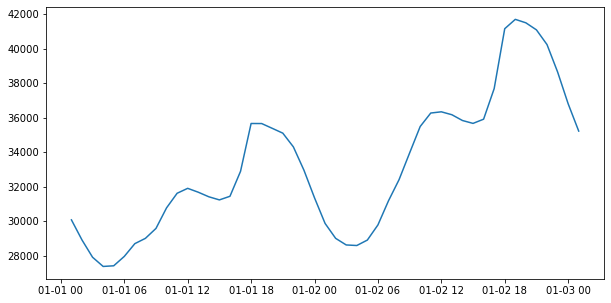

In [151]:
plt.figure(figsize=(10, 5))
plt.plot(df2["Datetime"][1:50] , df2["Power_MWH"][1:50])

By creating a new dataframe *df2*, seeing the index and plotting it, the assumption of the *Datetime* column was not in order is proven, therefore I will order the original dataframe.

In [152]:
df = df.sort_values(by = ["Datetime"], ascending = True)
df.reset_index(inplace = True)
df

,Datetime,Power_MWH
0,2010-01-01 00:00:00,31647.0
8734,2010-01-01 01:00:00,30075.0
8735,2010-01-01 02:00:00,28907.0
8736,2010-01-01 03:00:00,27906.0
8737,2010-01-01 04:00:00,27373.0
...,...,...
70139,2018-08-02 20:00:00,44057.0
70140,2018-08-02 21:00:00,43256.0
70141,2018-08-02 22:00:00,41552.0
70142,2018-08-02 23:00:00,38500.0


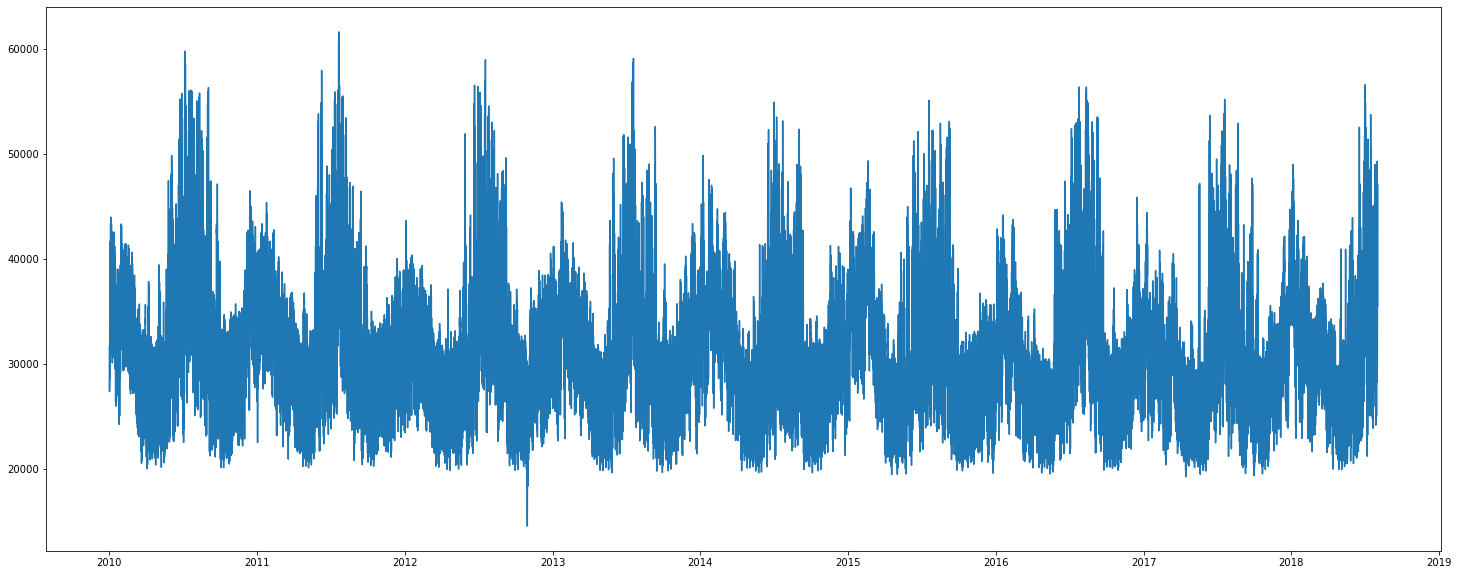

In [154]:
plt.figure(figsize=(25, 10))
plt.plot(df["Datetime"], df["Power_MWH"])
plt.show()

Now the series has the correct order.

With the plot it apperars that the series is stationary and has seasonality. 

The following plots are to zoom in the series and learn a bit more about its seasonality.

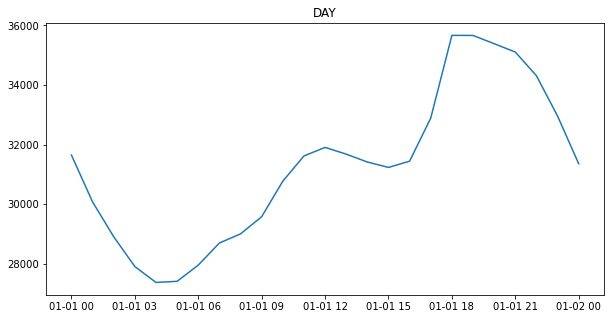

In [16]:
plt.figure(figsize=(10, 5))

n = 25 # a week
plt.plot(df["Datetime"][0:n], df["Power_MWH"][0:n])
plt.title("DAY")
plt.show()

There's a spike on enegy consumption around 6pm which decreases hourly until its lowest point between 4 and 5 am.

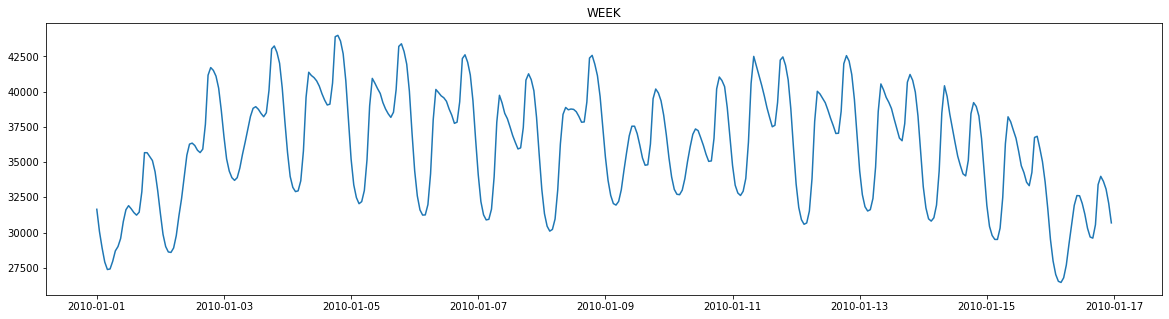

In [17]:
plt.figure(figsize=(20, 5))

n = 24*8*2 # two weeks
plt.plot(df["Datetime"][0:n], df["Power_MWH"][0:n])
plt.title("WEEK")
plt.show()

This behavior seems to be the same every day.

Let's grouping data to continue with the seasonality analysis, as it will help later to set the parameters for the model.

In [155]:
df["date"] = pd.to_datetime(df["Datetime"]).dt.date
df["date"] = pd.to_datetime(df["date"])

In [156]:
df["time"] = pd.to_datetime(df["Datetime"]).dt.time

In [157]:
df["month"] = pd.to_datetime(df["Datetime"]).dt.month

In [158]:
df["hour_of_day"] = pd.to_datetime(df["Datetime"]).dt.hour

In [159]:
df["weekday"] = pd.to_datetime(df["Datetime"]).dt.weekday

In [160]:
df.head()

,index,Datetime,Power_MWH,date,time,month,hour_of_day,weekday
0,0,2010-01-01 00:00:00,31647.0,2010-01-01,00:00:00,1,0,4
1,8734,2010-01-01 01:00:00,30075.0,2010-01-01,01:00:00,1,1,4
2,8735,2010-01-01 02:00:00,28907.0,2010-01-01,02:00:00,1,2,4
3,8736,2010-01-01 03:00:00,27906.0,2010-01-01,03:00:00,1,3,4
4,8737,2010-01-01 04:00:00,27373.0,2010-01-01,04:00:00,1,4,4


In [161]:
df.dtypes

index                   int64
Datetime       datetime64[ns]
Power_MWH             float64
date           datetime64[ns]
time                   object
month                   int64
hour_of_day             int64
weekday                 int64
dtype: object

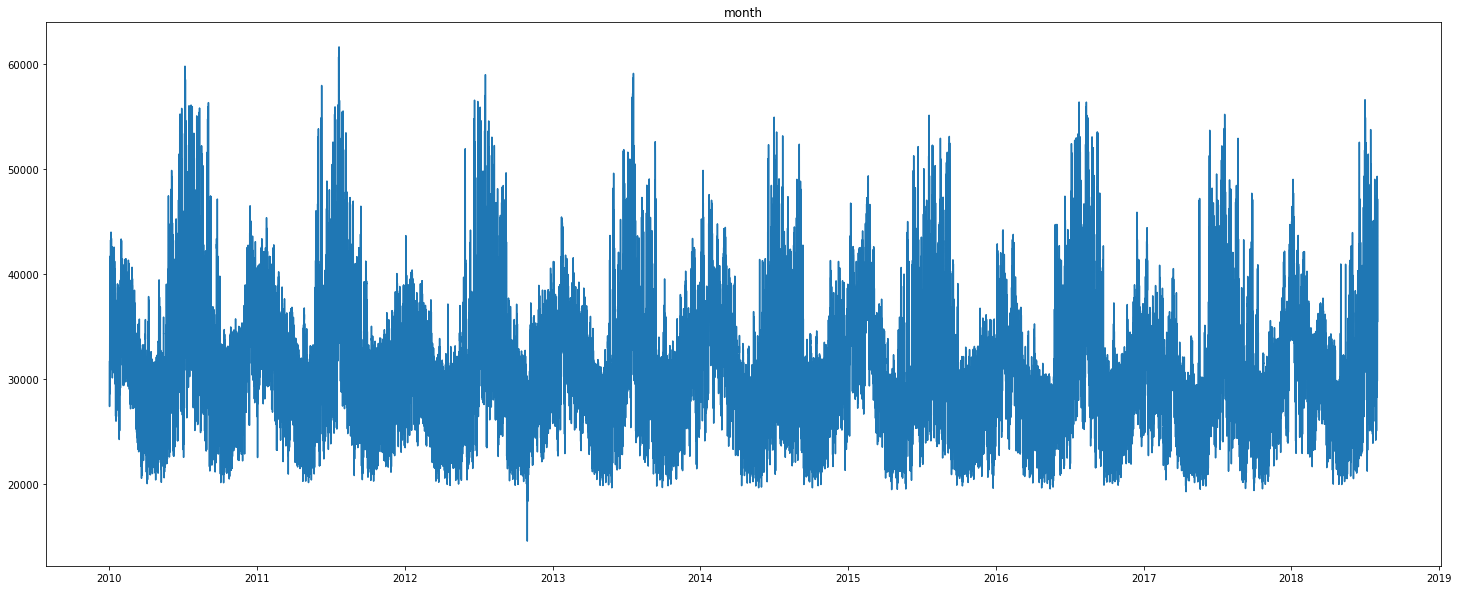

In [162]:
# ALL DATA PLOT

plt.figure(figsize=(25, 10))
plt.plot(df["Datetime"], df["Power_MWH"])
plt.title("month")
plt.show()

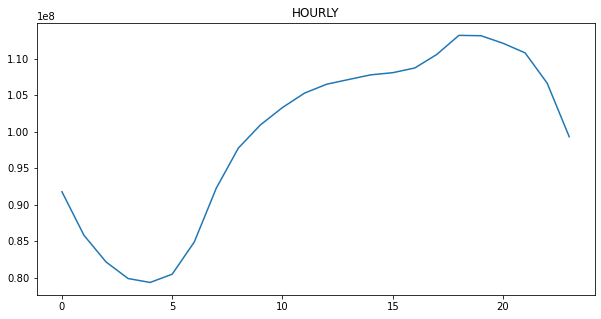

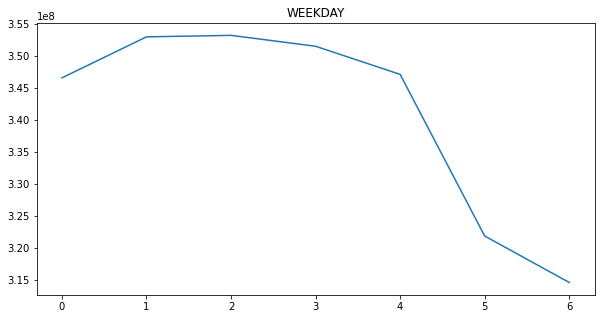

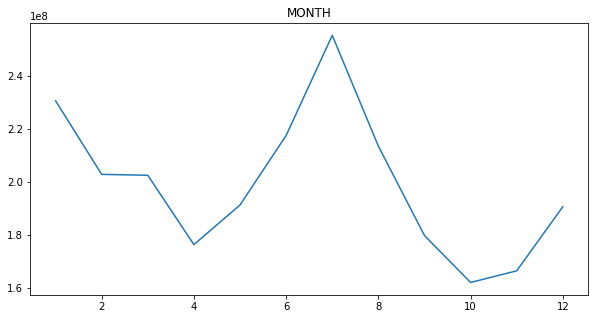

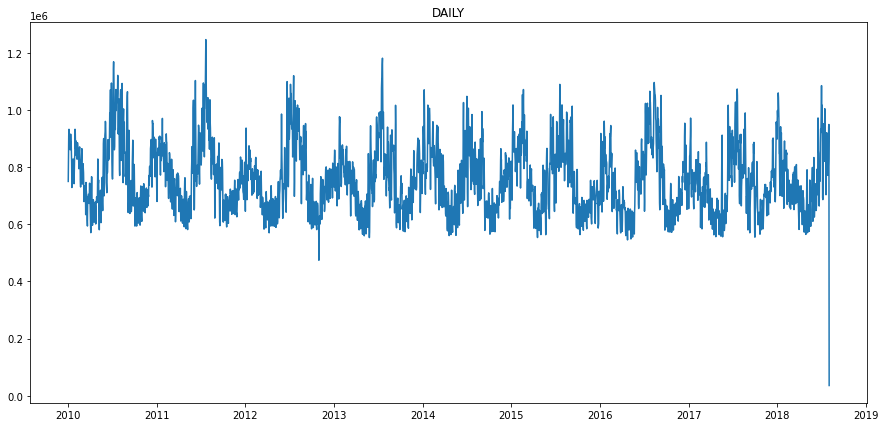

In [163]:
# GROUPED DATA

# HOURLY
df2 = df["Power_MWH"].groupby(df["hour_of_day"]).sum()
plt.figure(figsize=(10, 5))
plt.plot(df2)
plt.title("HOURLY")
plt.show()


# WEEKDAY
df2 = df["Power_MWH"].groupby(df["weekday"]).sum()
plt.figure(figsize=(10, 5))
plt.plot(df2)
plt.title("WEEKDAY")
plt.show()


# MONTLY
df2 = df["Power_MWH"].groupby(df["month"]).sum()
plt.figure(figsize=(10, 5))
plt.plot(df2)
plt.title("MONTH")
plt.show()


# DAILY
df2 = df["Power_MWH"].groupby(df["date"]).sum()
plt.figure(figsize=(15, 7))
plt.plot(df2)
plt.title("DAILY")
plt.show()

In avarage, this is the behavior of the series along the 8+ yeas of data on summer months and winter months is when there are the highest energy consumption spikes; the energy consumption is higher during weekdays than during the weekends; and in average from 5 pm to 9 pm the consumption is higher. 

# Model

Three models were build as examples of different aproaches to generate the forecast.

## Prophet

This is a model developed by Meta. It's and additive model that learns well from historical data and trends to fit yearly, monthly and daily seasonality.

In [175]:
df2 = df["Power_MWH"].groupby(df["date"]).sum().to_frame().reset_index()
df2.head()

,date,Power_MWH
0,2010-01-01,750586.0
1,2010-01-02,837421.0
2,2010-01-03,910921.0
3,2010-01-04,933310.0
4,2010-01-05,915793.0


In [176]:
df2.columns = ["ds", "y"]
df2

,ds,y
0,2010-01-01,750586.0
1,2010-01-02,837421.0
2,2010-01-03,910921.0
3,2010-01-04,933310.0
4,2010-01-05,915793.0
...,...,...
3132,2018-07-30,790978.0
3133,2018-07-31,828938.0
3134,2018-08-01,941539.0
3135,2018-08-02,950233.0


In [30]:
m = Prophet()
m.fit(df2)

00:10:37 - cmdstanpy - INFO - Chain [1] start processing
00:10:38 - cmdstanpy - INFO - Chain [1] done processing


In [34]:
future = m.make_future_dataframe(freq = "H", periods = 24*7*12)

In [35]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(30)

,ds,yhat,yhat_lower,yhat_upper
5123,2018-10-24 19:00:00,657721.968637,565713.662707,750821.245255
5124,2018-10-24 20:00:00,657410.834096,568283.068930,745999.252774
5125,2018-10-24 21:00:00,657091.834038,563425.721283,751518.402628
5126,2018-10-24 22:00:00,656768.186478,566562.220473,749101.680844
5127,2018-10-24 23:00:00,656442.875449,562141.320028,752690.309492
5128,2018-10-25 00:00:00,656118.572314,561986.476612,751850.496894
5129,2018-10-25 01:00:00,655797.561018,567886.932298,750263.844347
5130,2018-10-25 02:00:00,655481.668482,563213.293135,743051.866204
5131,2018-10-25 03:00:00,655172.201354,563663.285523,748175.150392
5132,2018-10-25 04:00:00,654869.890196,558377.126633,747527.711255


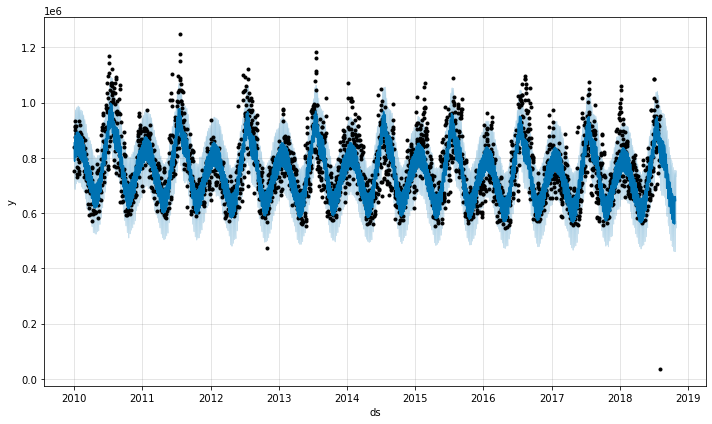

In [36]:
fig1 = m.plot(forecast)

Althoug the option for "hourly" was set, the hourly forecast in this model is based on the daily average because of the way Prophet receives and accept date data (on daily basis).

## ARIMA and SARIMA

ARIMA means Auto Regressive Integrated Moving Average and has three parameters that help the model to learn from the data trends and seasonality.

ARIMA and SARIMA are well known and used time series models. These two models are autoregressive parametric models, they use historical data to predict future behavior and forecasting. The parameters are p, d and q, where:
* p = autoregressive component. Autocorrelation Function (ACF) is used to determine the value.
* d = how many times do we need to differentiate our variable to achieve stationary. Can be determined with the Dickey-Fuller test. If d=0, then is an ARMA model.
* q = moving average component. Partial Autocorrelation Function (PACF) is used to determine the value.


In the case of SARIMA, which allows seasonality, four are other four parameters beside the ones mentioned above:
* P = lags in the autoregressive model.
* D = differencing / integration order.
* Q =  moving average lags.
*  S (or m) = seasonality.

If a series is stationary is one of the first things to determine, and that can be achieved with the Augmented Dickey-Fuller test (ADF), which helps to know if unit root, white noise and stationary can be known. If the p-value from the test is smaller than a significance value of reference (usually alpha = 0.05), then can be concluded that the series has no unit root and is stationary and the value of d is zero. 

To choose the best combination of parameters, the Akaike information criterion, or AIC, is one of the most used methods to compare models and the one with the smallest AIC is chosen.




### ARIMA

The first step is to prove if the series is stationary or not. There are different test to prove this, but in this case the Augmentated Dickey-Fuller test is used. 

In the previous plots, the series appear to be stationary, but lets use the statisticall test to validate this.

In [178]:
def dickey_fuller_test(values):
    print("Augmented Dickey-Fuller Test result")
    result = adfuller(values.dropna(), autolag = "AIC") 
    
    labels = ["ADF test statistic", "p-value", "Lags", "Observations"]
    test_output = pd.Series(result[0:4], index = labels)

    for key, val in result[4].items():
        test_output[f"Critical value ({key})"] = val
        
    print(test_output.to_string())          
    
     
dickey_fuller_test(df['Power_MWH'])


Augmented Dickey-Fuller Test result
ADF test statistic     -1.319001e+01
p-value                 1.149179e-24
Lags                    6.300000e+01
Observations            7.519100e+04
Critical value (1%)    -3.430437e+00
Critical value (5%)    -2.861578e+00
Critical value (10%)   -2.566790e+00


In this case, the ADF shows that the series is stationary. If it wasn’t, then this should be fixed by differencing methods. 

To choose the best combination of parameters, the Akaike information criterion, or AIC, is one of the most used methods to compare models and the one with the smallest AIC is chosen.


The p and q parameters can be obtain by ACF and PACF functions. In this case, ```auto_arima```is used to get the parameters combination with the smallest AIC.

Note: Running ```auto_arima``` killed my kernel several times, so I decided to use only 10% of the data for forecast. By doing this I undestand that the properties previously tested can be different, but I will proceed anyway keeping this in mind and knowing the forecast can be negatively affected. By getting the p,d,q parameters, I fit and predict the model and use the complet dataset.

In [38]:
# only 10% of data (most recent)
df3 = df[-round(len(df)*.1) : ]
df3

,index,Datetime,Power_MWH,date,time,month,hour_of_day,weekday
67729,63747,2017-09-23 11:00:00,30491.0,2017-09-23,11:00:00,9,11,5
67730,63748,2017-09-23 12:00:00,32225.0,2017-09-23,12:00:00,9,12,5
67731,63749,2017-09-23 13:00:00,33913.0,2017-09-23,13:00:00,9,13,5
67732,63750,2017-09-23 14:00:00,35508.0,2017-09-23,14:00:00,9,14,5
67733,63751,2017-09-23 15:00:00,37006.0,2017-09-23,15:00:00,9,15,5
...,...,...,...,...,...,...,...,...
75250,70139,2018-08-02 20:00:00,44057.0,2018-08-02,20:00:00,8,20,3
75251,70140,2018-08-02 21:00:00,43256.0,2018-08-02,21:00:00,8,21,3
75252,70141,2018-08-02 22:00:00,41552.0,2018-08-02,22:00:00,8,22,3
75253,70142,2018-08-02 23:00:00,38500.0,2018-08-02,23:00:00,8,23,3


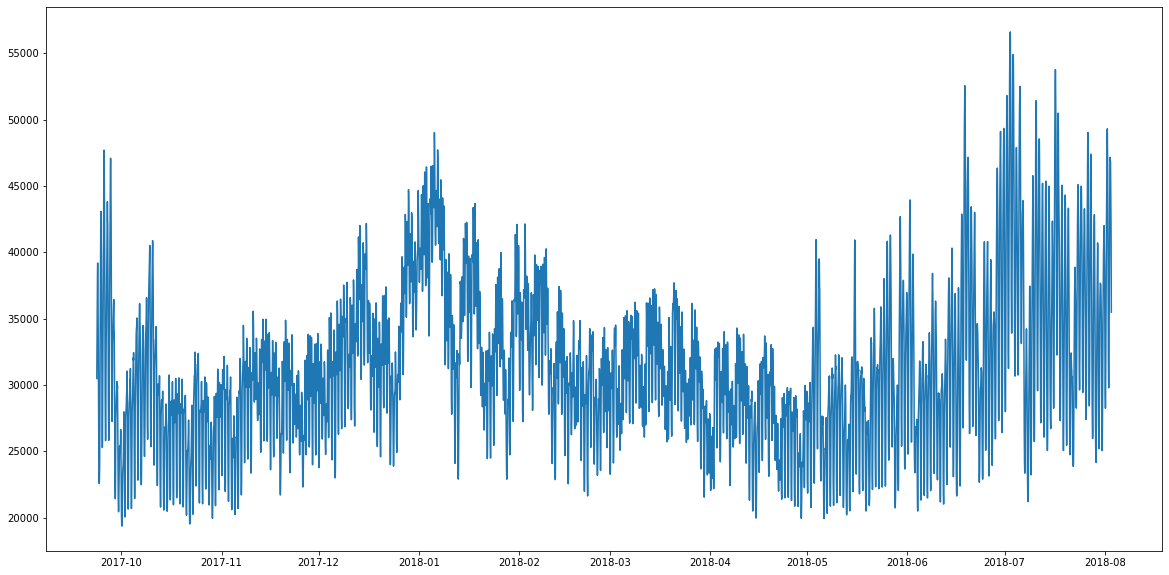

In [39]:
plt.figure(figsize=(20, 10))
plt.plot(df3["Datetime"], df3["Power_MWH"])
plt.show()


In [40]:
df3.set_index("Datetime", inplace = True)
df3.head()

df3.drop(columns = ["index", "date", "time", "month", "hour_of_day", "weekday"], inplace = True)
df3.head()

/Users/wera/opt/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,Power_MWH
Datetime,
2017-09-23 11:00:00,30491.0
2017-09-23 12:00:00,32225.0
2017-09-23 13:00:00,33913.0
2017-09-23 14:00:00,35508.0
2017-09-23 15:00:00,37006.0


In [55]:
#Standard ARIMA Model #ARIMA(p,d,q)

ARIMA_model = pm.auto_arima(df3["Power_MWH"], 
                      start_p = 0, 
                      start_q = 0,
                      test = "adf", 
                      max_p = 3, max_q = 3, 
                      m = 1, 
                      d = None, # let model determine 'd'. For ADF I lknow should 0, but let's test anyway.
                      seasonal = False, # No Seasonality ARIMA
                      trace = True, 
                      error_action = "warn",
                      suppress_warnings = True,
                      stepwise = True)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=177373.928, Time=1.53 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=167070.449, Time=0.95 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=121995.337, Time=0.59 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=117703.937, Time=0.32 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=120046.217, Time=0.15 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=inf, Time=4.01 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=117479.895, Time=1.57 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=118776.987, Time=0.93 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=116531.034, Time=2.37 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=116532.928, Time=1.99 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=117477.757, Time=2.42 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=116916.814, Time=2.06 sec

Best model:  ARIMA(3,0,2)(0,0,0)[0]          
Total fit time: 18.999 seconds


In [56]:
ARIMA_model.summary() #ARIMA(p,d,q) ARIMA(p=3,d=0,q=2)

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 7526
Model:               SARIMAX(3, 0, 2)   Log Likelihood              -58259.517
Date:                Mon, 24 Oct 2022   AIC                         116531.034
Time:                        22:58:07   BIC                         116572.591
Sample:                             0   HQIC                        116545.302
                               - 7526                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          2.7007      0.006    415.626      0.000       2.688       2.713
ar.L2         -2.4971      0.012   -205.550      0.000      -2.521      -2.473
ar.L3          0.7963      0.006    130.414      0.000       0.784       0.808
ma.L1         -0.4563      0.010    -44.163      0.000      -0.477      -0.436
ma.L2         -0.4734      0.011    -44.608      0.000      -0.494      -0.453
sigma2      3.096e+05   1.35e-08    2.3e+13      0.000     3.1e+05     3.1e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              2252.37
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               0.64   Skew:                            -0.79
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.17
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.25e+30. Standard errors may be unstable.
"""

The summary suggset that the best model is an ARIMA(3,0,2), which will be used to fit and predict. The bellow charts show that the model could be improved, but let's try it.

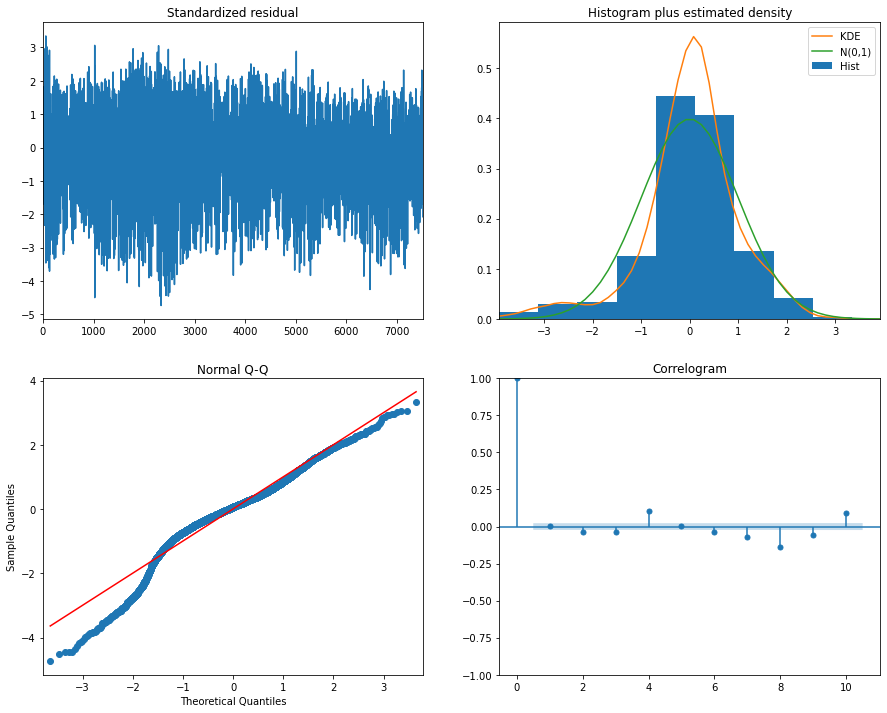

In [57]:
ARIMA_model.plot_diagnostics(figsize=(15,12))
plt.show()

Using ```sm.tsa.arima.ARIMA``` now that I have the parameters from to ```auto_arima```

In [180]:
ARIMA_m = sm.tsa.arima.ARIMA(df["Power_MWH"], order=(3,0,1))
ARIMA_m = ARIMA_m.fit()

ARIMA_m.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              Power_MWH   No. Observations:                75255
Model:                 ARIMA(3, 0, 1)   Log Likelihood             -592486.054
Date:                Tue, 25 Oct 2022   AIC                        1184984.108
Time:                        12:49:48   BIC                        1185039.479
Sample:                             0   HQIC                       1185001.129
                              - 75255                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.173e+04     99.003    320.495      0.000    3.15e+04    3.19e+04
ar.L1          1.7864      0.008    223.255      0.000       1.771       1.802
ar.L2         -0.9031      0.016    -57.800      0.000      -0.934      -0.872
ar.L3          0.0737      0.008      9.103      0.000       0.058       0.090
ma.L1          0.4713      0.008     60.776      0.000       0.456       0.486
sigma2      4.036e+05   1614.650    249.948      0.000       4e+05    4.07e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):             29605.08
Prob(Q):                              0.89   Prob(JB):                         0.00
Heteroskedasticity (H):               0.75   Skew:                            -0.77
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.66
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [181]:
prediction = pd.DataFrame(ARIMA_m.predict(len(df3)+1, len(df3)+24))
prediction

,predicted_mean
7527,30453.232578
7528,32366.329784
7529,36424.508140
7530,32154.960968
7531,33205.909855
7532,31413.741433
7533,29284.188111
7534,26463.183825
7535,25239.005665
7536,23942.200088


In [182]:
pred_date = [df3.index[-1]+ DateOffset(hours=x)for x in range(1,25)]
pred_date

[Timestamp('2018-08-03 01:00:00'),
 Timestamp('2018-08-03 02:00:00'),
 Timestamp('2018-08-03 03:00:00'),
 Timestamp('2018-08-03 04:00:00'),
 Timestamp('2018-08-03 05:00:00'),
 Timestamp('2018-08-03 06:00:00'),
 Timestamp('2018-08-03 07:00:00'),
 Timestamp('2018-08-03 08:00:00'),
 Timestamp('2018-08-03 09:00:00'),
 Timestamp('2018-08-03 10:00:00'),
 Timestamp('2018-08-03 11:00:00'),
 Timestamp('2018-08-03 12:00:00'),
 Timestamp('2018-08-03 13:00:00'),
 Timestamp('2018-08-03 14:00:00'),
 Timestamp('2018-08-03 15:00:00'),
 Timestamp('2018-08-03 16:00:00'),
 Timestamp('2018-08-03 17:00:00'),
 Timestamp('2018-08-03 18:00:00'),
 Timestamp('2018-08-03 19:00:00'),
 Timestamp('2018-08-03 20:00:00'),
 Timestamp('2018-08-03 21:00:00'),
 Timestamp('2018-08-03 22:00:00'),
 Timestamp('2018-08-03 23:00:00'),
 Timestamp('2018-08-04 00:00:00')]

In [183]:
pred_date = pd.DataFrame(index = pred_date, columns = df3.columns)
pred_date

,Power_MWH
2018-08-03 01:00:00,NaN
2018-08-03 02:00:00,NaN
2018-08-03 03:00:00,NaN
2018-08-03 04:00:00,NaN
2018-08-03 05:00:00,NaN
2018-08-03 06:00:00,NaN
2018-08-03 07:00:00,NaN
2018-08-03 08:00:00,NaN
2018-08-03 09:00:00,NaN
2018-08-03 10:00:00,NaN


In [184]:
prediction.set_index(pred_date.index, inplace = True)
prediction

,predicted_mean
2018-08-03 01:00:00,30453.232578
2018-08-03 02:00:00,32366.329784
2018-08-03 03:00:00,36424.508140
2018-08-03 04:00:00,32154.960968
2018-08-03 05:00:00,33205.909855
2018-08-03 06:00:00,31413.741433
2018-08-03 07:00:00,29284.188111
2018-08-03 08:00:00,26463.183825
2018-08-03 09:00:00,25239.005665
2018-08-03 10:00:00,23942.200088


In [185]:
prediction.rename(columns={"predicted_mean":"prediction"}, inplace = True)
prediction


,prediction
2018-08-03 01:00:00,30453.232578
2018-08-03 02:00:00,32366.329784
2018-08-03 03:00:00,36424.508140
2018-08-03 04:00:00,32154.960968
2018-08-03 05:00:00,33205.909855
2018-08-03 06:00:00,31413.741433
2018-08-03 07:00:00,29284.188111
2018-08-03 08:00:00,26463.183825
2018-08-03 09:00:00,25239.005665
2018-08-03 10:00:00,23942.200088


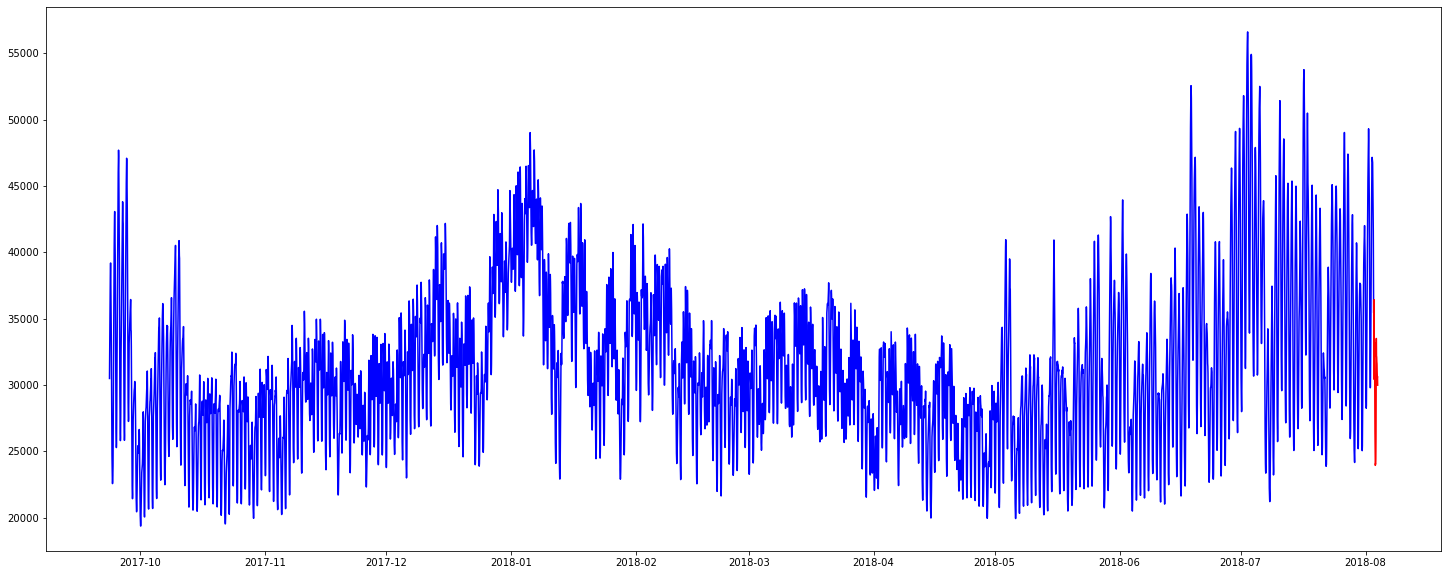

In [186]:
plt.figure(figsize=(25, 10))
plt.plot(df3.index, df3["Power_MWH"], "blue")
plt.plot(prediction.index, prediction["prediction"], "red")


### SARIMA

In [ ]:
SARIMA_model = pm.auto_arima(train["Power_MWH"], 
                             start_p = 0, start_q = 0,
                             max_p = 3, max_q = 2,
                             start_P = 0, start_Q = 0,
                             max_P = 2, max_Q = 2, max_D = 2,
                             m = 24,
                             seasonal = True,
                             d = None,
                             D = 1,
                             trace = True,
                             error_action = "warn",
                             suppress_warnings = True,
                             stepwise = True)



Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[24] intercept   : AIC=97508.588, Time=0.91 sec
 ARIMA(1,0,0)(1,1,0)[24] intercept   : AIC=81078.655, Time=34.78 sec
 ARIMA(0,0,1)(0,1,1)[24] intercept   : AIC=inf, Time=44.37 sec
 ARIMA(0,0,0)(0,1,0)[24]             : AIC=97506.851, Time=0.87 sec
 ARIMA(1,0,0)(0,1,0)[24] intercept   : AIC=81288.782, Time=3.46 sec
 ARIMA(1,0,0)(2,1,0)[24] intercept   : AIC=80657.165, Time=82.26 sec
 ARIMA(1,0,0)(2,1,1)[24] intercept   : AIC=inf, Time=252.39 sec
 ARIMA(1,0,0)(1,1,1)[24] intercept   : AIC=inf, Time=107.83 sec
 ARIMA(0,0,0)(2,1,0)[24] intercept   : AIC=97417.775, Time=39.39 sec
 ARIMA(2,0,0)(2,1,0)[24] intercept   : AIC=76672.236, Time=149.47 sec
 ARIMA(2,0,0)(1,1,0)[24] intercept   : AIC=77069.977, Time=60.93 sec
 ARIMA(2,0,0)(2,1,1)[24] intercept   : AIC=inf, Time=296.48 sec
 ARIMA(2,0,0)(1,1,1)[24] intercept   : AIC=inf, Time=105.51 sec
 ARIMA(3,0,0)(2,1,0)[24] intercept   : AIC=75816.606, Time=183.00 sec
 ARIMA(3,0,0)(1,1,

While running ```auto_arima``` the kernel crashed several times, but one of the runnings was the one shown in the image below. With the parameters (3,0,0)x(2,1,1,6) the AIC is smaller that the ARIMA model previously shown.


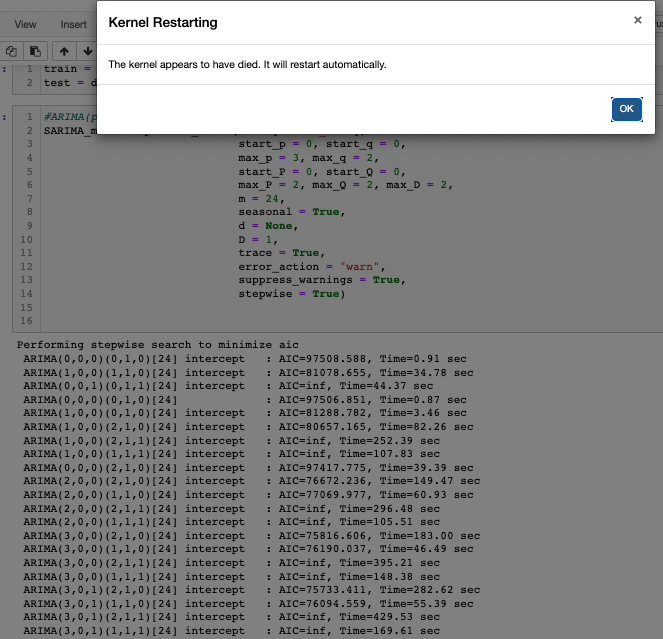



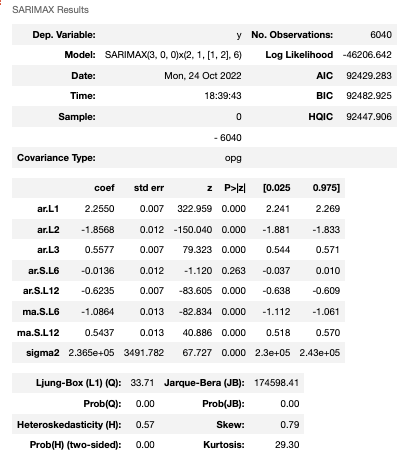

The correlogram and QQplot also shoe a better adjustment compared with ARIMA.

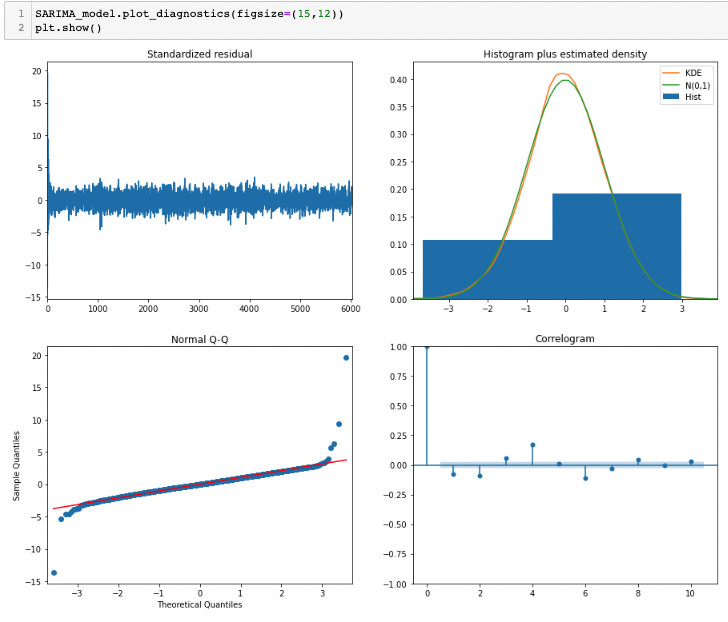

Therefore this parameters will be used yo fit and predict the SARIMA model.

In [124]:
SARIMA_m = SARIMAX(df["Power_MWH"], order = (3, 0, 0), seasonal_order = ((2,1,1,6)))
SARIMA_m = SARIMA_m.fit()

/Users/wera/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/wera/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.78957D+01    |proj g|=  1.19384D+02

At iterate    5    f=  8.23216D+00    |proj g|=  3.37900D-01

At iterate   10    f=  8.06505D+00    |proj g|=  8.73653D-02

At iterate   15    f=  8.04001D+00    |proj g|=  2.94172D-02

At iterate   20    f=  8.01538D+00    |proj g|=  7.32263D-03

At iterate   25    f=  8.01126D+00    |proj g|=  3.61318D-03

At iterate   30    f=  8.01036D+00    |proj g|=  1.72756D-03

At iterate   35    f=  8.00841D+00    |proj g|=  2.68414D-02

At iterate   40    f=  7.98281D+00    |proj g|=  6.05942D-02

At iterate   45    f=  7.96110D+00    |proj g|=  2.10946D-02

At iterate   50    f=  7.95936D+00    |proj g|=  1.06647D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/Users/wera/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


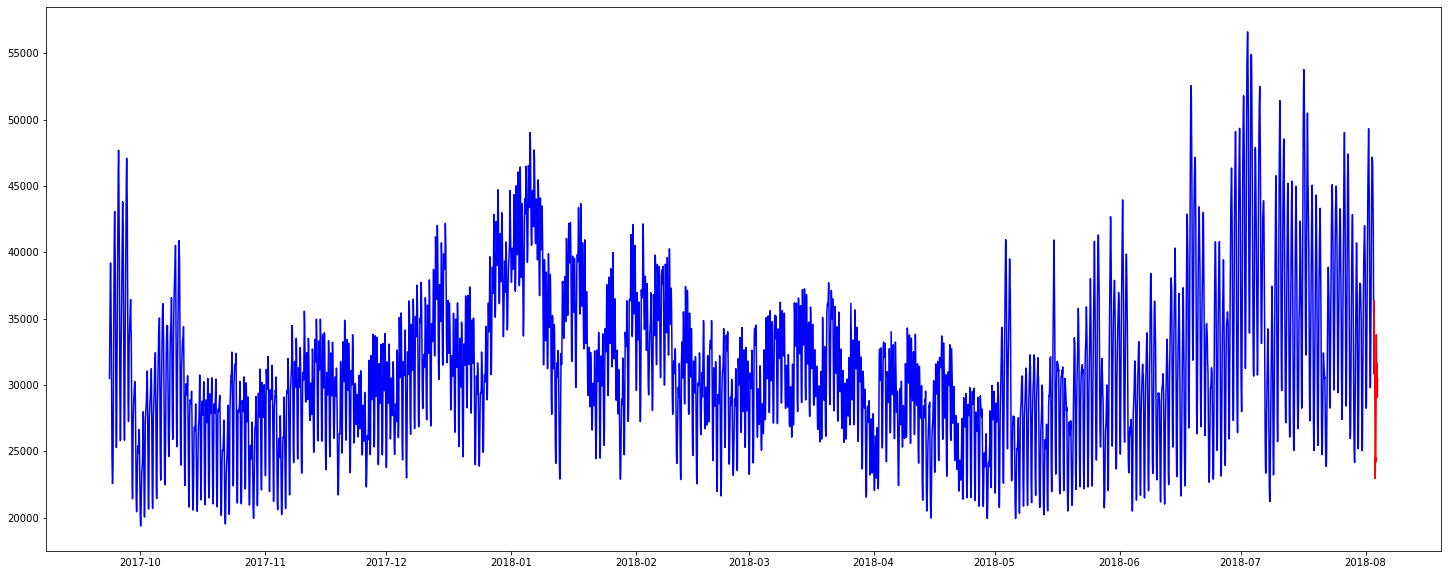

In [195]:
prediction = pd.DataFrame(SARIMA_m.predict(len(df3)+1, len(df3)+24))
prediction

pred_date = [df3.index[-1]+ DateOffset(hours=x)for x in range(1,25)]
pred_date

pred_date = pd.DataFrame(index = pred_date, columns = df3.columns)
pred_date

prediction.set_index(pred_date.index, inplace = True)
prediction

prediction.rename(columns={"predicted_mean":"prediction"}, inplace = True)
prediction

plt.figure(figsize=(25, 10))
plt.plot(df3.index, df3["Power_MWH"], "blue")
plt.plot(prediction.index, prediction["prediction"], "red")

A more complex forecast model is the Long-Short Term Memory, or LSTM, which is a Recurrent Neural Network. This type of Networks have loops and in each loop add memory and feedback which help to learn and generalize data inputs. LSTM Network uses backpropagation through time and uses blocks of memory instead of isolated neurons. Thanks to these properties, LSTM is powerful when forecasting data.  

For the purpose of the case, this machine learning model won't be developed but is a good option to consider as good approach for forecasting time series data.